In [1]:
%%capture
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
!pip install openpyxl
import matplotlib.pyplot as plt

In [2]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

In [3]:
max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)

x_group = pd.get_dummies(max_elemental['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(max_elemental['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(max_elemental['M_M_group'],prefix='m_g',dtype=float)
max_elemental = max_elemental.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
max_elemental = pd.concat([max_elemental,x_group,a_group,m_group],axis=1)

In [5]:
tree = DecisionTreeClassifier().fit(X=max_elemental.drop(['class'],axis=1),
                                    y=max_elemental['class'])

In [6]:
max_elemental['tree_pred'] = tree.predict(max_elemental.drop(['class'],axis=1))

In [12]:
pos = max_elemental[max_elemental['tree_pred'] == 1]

In [23]:
list_true_pos = list(pos[pos['class'] == 1].index)

In [55]:
list_false_pos = list(pos[pos['class'] == 0].index)

In [ ]:
#the recall is 0.8

In [17]:
false_n = max_elemental[max_elemental['tree_pred'] == 0]
false_n = false_n[false_n['class'] == 1]

In [18]:
false_n

,M_M_atomic_number,M_M_atomic_mass,M_M_molar_volume,M_M_density,M_M_atomic_radius,M_M_atomic_radius_calculated,M_M_van_der_waals_radius,M_M_average_ionic_radius,M_M_average_cationic_radius,M_M_average_anionic_radius,...,a_g_14,a_g_15,a_g_16,m_g_3,m_g_4,m_g_5,m_g_6,m_g_7,m_g_8,tree_pred
compound_formula,,,,,,,,,,,,,,,,,,,,,
Ti2SC,22,47.867,10,4.7867,1.4,1.76,2.11,0.851667,0.851667,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Ti3SiC2,22,47.867,10,4.7867,1.4,1.76,2.11,0.851667,0.851667,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Ti3SnC2,22,47.867,10,4.7867,1.4,1.76,2.11,0.851667,0.851667,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#the titanium based are not well predicted

In [21]:
list_fn = list(false_n.index)

In [56]:
to_plot_tp = max_calculated.filter(items=list_true_pos,axis=0)
to_plot_fn = max_calculated.filter(items=list_fn,axis=0)
other_points = max_calculated.drop(list_fn,axis=0)
other_points = max_calculated.drop(list_true_pos,axis=0)
tech_possible = other_points[other_points['dH']<30]
tech_possible = tech_possible[tech_possible['dEf']<30]
false_positives = other_points.filter(items=list_false_pos,axis=0)

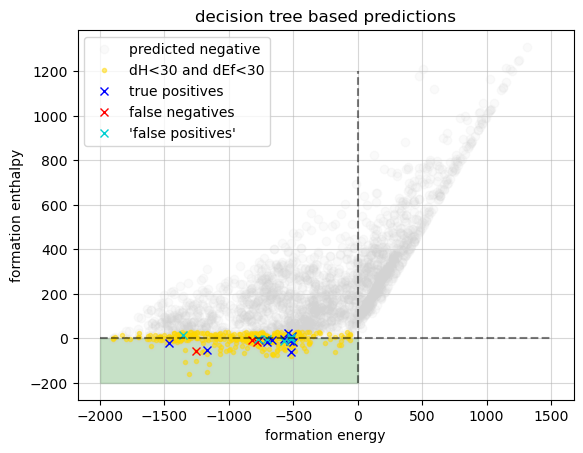

In [60]:
fig, ax = plt.subplots()
ax.plot(other_points['dEf'],other_points['dH'],'o',color='lightgrey',alpha=0.1,label='predicted negative')
ax.plot(tech_possible['dEf'],tech_possible['dH'],'.',color='gold',label='dH<30 and dEf<30',alpha=0.5)
ax.plot(to_plot_tp['dEf'],to_plot_tp['dH'],'bx',label='true positives')
ax.plot(to_plot_fn['dEf'],to_plot_fn['dH'],'rx',label='false negatives')
ax.plot(false_positives['dEf'],false_positives['dH'],'x',color='darkturquoise',label="'false positives'")
ax.grid(alpha=0.5)
ax.set_xlabel('formation energy')
ax.set_ylabel('formation enthalpy')
ax.set_title('decision tree based predictions')
plt.legend()
ax.fill_between(np.linspace(-2000,0,2,endpoint=True),y1=-200,y2=0,color='forestgreen',alpha=0.25)
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
#plt.savefig('decision tree based predictions.png')

In [50]:
recall = len(list_true_pos)/15
proba = pos.shape[0]/n_samples

In [51]:
ll = (recall**2)/proba

In [53]:
ll

80.42666666666668

In [54]:
recall

0.8

In [ ]:
#probably a lot of over fitting, we might 

In [61]:
max_calculated.filter(items=list_false_pos,axis=0)

,n,a,c,dMX,dMM,dMA,dAA,rMX,rMA,e_M,...,volume.pa,density,dEf,E_pa,dH,M,A,X,PU_label,year
V3AlC2,2,2.92240,17.9252,1.15626,2.31253,2.16877,8.96260,2.04654,2.74779,1.11395,...,11.048190,5.105880,-516.357197,-8.757388,4.952521,V,Al,C,0.0,NaN
Nb3AlC2,2,3.13544,19.2382,1.28453,2.56907,2.24048,9.61910,2.22006,2.88041,1.17204,...,13.649262,6.685555,-521.123974,-9.271629,-1.775574,Nb,Al,C,0.0,NaN
Ta3AlC2,2,3.10532,19.2624,1.29058,2.58116,2.23444,9.63120,2.20916,2.86480,1.22384,...,13.405185,12.260262,-569.868823,-10.198610,-10.541861,Ta,Al,C,1.0,2006.0
Ti4AlC3,3,3.08433,23.5787,1.20330,2.40585,2.28478,11.78935,2.15131,2.89677,1.49083,...,12.140948,4.350754,-775.392812,-8.651155,-0.704936,Ti,Al,C,0.0,NaN
Ti4ZnC3,3,3.08192,23.5721,1.20469,2.40954,2.27895,11.78605,2.15103,2.89131,1.50962,...,12.118607,5.016463,-701.495208,-8.266493,-2.399021,Ti,Zn,C,0.0,NaN
Ti3AlN2,2,3.00514,18.4745,1.19050,2.38099,2.23763,9.23725,2.10485,2.83148,1.38390,...,12.040685,4.564764,-1354.764883,-8.705385,14.197895,Ti,Al,N,0.0,NaN
